In [1]:
from rdflib import Graph
from rdflib.plugins.sparql.processor import SPARQLResult
import pandas as pd
import numpy as np
import seaborn as sns
import Auxiliary
import torch

import Link_Prediction as lp
import scipy
from math import*
from decimal import Decimal

In [2]:
path = 'SubsymbolicSystem/Uniform/'

In [3]:
g1 = Graph()
g1.parse(path + "G1/Training_RDF/train_4.ttl", format="ttl")

g2 = Graph()
g2.parse(path + "G2/Training_RDF/train_4.ttl", format="ttl")

<Graph identifier=N767c36ac0980469880a2ded1b652c42f (<class 'rdflib.graph.Graph'>)>

In [4]:
def query_treatment_by_class(response):
    query = """
    PREFIX ex: <http://example/> 

    select distinct ?treatment
    where {
        ?treatment ex:belong_to """+response+""" .
        }
        """
    return query


def sparql_results_to_df(results: SPARQLResult) -> pd.DataFrame:
    """
    Export results from an rdflib SPARQL query into a `pandas.DataFrame`,
    using Python types. See https://github.com/RDFLib/rdflib/issues/1179.
    """
    return pd.DataFrame(
        data=([None if x is None else x.toPython() for x in row] for row in results),
        columns=[str(x) for x in results.vars],
    )

In [5]:
def get_TP_treatment(path, graph, fold, model, response, th):
    tf_testing, triple_test = lp.load_dataset(path, graph+'/test_'+str(fold)+'.ttl')
    predicted_heads_dec_eff = lp.predict_heads(model, 'ex:belong_to', response, tf_testing)
    threshold, threshold_index = lp.get_threshold(predicted_heads_dec_eff, th)
    tp_fp = predicted_heads_dec_eff.iloc[0:threshold_index + 1]
    fn_tn = predicted_heads_dec_eff.iloc[threshold_index+1:]
    fn = fn_tn.loc[fn_tn.in_training == True]
    tp = tp_fp.loc[tp_fp.in_training == True]
    return list(fn.head_label.values), list(tp.head_label.values)


def intersection_list(list1, list2):  
    return set(list1).intersection(list2)


def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

def manhattan_distance(x,y):
      return sum(abs(a-b) for a,b in zip(x,y))

def cosine_sim(x, y):
    return abs(1 - scipy.spatial.distance.cosine(x, y))

 
def nth_root(value, n_root):
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
 
def minkowski_distance(x,y,p_value):
    return nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),p_value)


def matrix_similarity(new_df, f_dist):
    array = new_df.set_index('target')
    entity = list(array.index.values)
    cosine_matrix = pd.DataFrame(index=entity, columns=entity)
    cosine_matrix = cosine_matrix.fillna(0.0)
    sim_val = 0

    for index, row in array.iterrows():
        for indexC, rowC in array.iterrows():
            sim = f_dist(row.values, rowC.values)
            sim = round(sim, 5)
            cosine_matrix.at[index, indexC] = sim
            if sim > sim_val and index != indexC:
                sim_val = sim
    return cosine_matrix, sim_val

def normalize_matrix(sim_matrix):
    max_val = max(sim_matrix.max())
    sim_matrix = 1 - sim_matrix.div(max_val)
    return sim_matrix

In [6]:
fold=4
m = 'TransH'
graph = 'G1'
th_lowEffect = 27.19266055 # means 399
model_g1 = torch.load(path + graph+'/' + m + str(fold) + '/trained_model.pkl', map_location='cpu')
g1_fn, g1_tp = get_TP_treatment(path, graph, fold, model_g1, 'ex:low_effect', th_lowEffect) # 'ex:low_effect'   'ex:effective'
graph = 'G2'
model_g2 = torch.load(path + graph+'/' + m + str(fold) + '/trained_model.pkl', map_location='cpu')
g2_fn, g2_tp = get_TP_treatment(path, graph, fold, model_g2, 'ex:low_effect', th_lowEffect)

In [7]:
intersection_list(g1_fn, g2_tp)

{'<http://example/Treatment/treatment102>',
 '<http://example/Treatment/treatment225>',
 '<http://example/Treatment/treatment312>',
 '<http://example/Treatment/treatment350>',
 '<http://example/Treatment/treatment355>'}

In [8]:
graph = 'G1'
entity_embedding_tensor, relation_embedding_tensor =  Auxiliary.get_learned_embeddings(model_g1)
tf_dataset, triple_dataset = Auxiliary.load_dataset(path, graph + '/train_'+str(fold)+'.ttl')
entity = list(intersection_list(g1_fn, g2_tp))+['ex:low_effect']
df_predicted_entities, new_df, df_g1 = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, entity,
                                                                                     tf_dataset)
new_df.replace('<http://example/Treatment/', '', regex=True, inplace=True)
new_df.replace('>', '', regex=True, inplace=True)

C:\Users\rivasa\Anaconda3\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [9]:
cosine_matrix, sim_val = matrix_similarity(new_df, cosine_sim)
summatory = sum(cosine_matrix.sum().values)
avg_sim = (summatory - cosine_matrix.shape[0]) / (cosine_matrix.shape[0]*(cosine_matrix.shape[0]-1))
display(sum(cosine_matrix.sum().values), avg_sim, cosine_matrix)

21.25904

0.5086346666666667

,treatment102,treatment225,treatment312,treatment350,treatment355,ex:low_effect
treatment102,1.00000,0.54485,0.29405,0.41346,0.50081,0.62688
treatment225,0.54485,1.00000,0.51776,0.39409,0.56162,0.56605
treatment312,0.29405,0.51776,1.00000,0.45444,0.43885,0.46797
treatment350,0.41346,0.39409,0.45444,1.00000,0.56456,0.68619
treatment355,0.50081,0.56162,0.43885,0.56456,1.00000,0.59794
ex:low_effect,0.62688,0.56605,0.46797,0.68619,0.59794,1.00000


In [10]:
graph = 'G2'
entity_embedding_tensor, relation_embedding_tensor =  Auxiliary.get_learned_embeddings(model_g2)
tf_dataset, triple_dataset = Auxiliary.load_dataset(path, graph + '/train_'+str(fold)+'.ttl')
entity = list(intersection_list(g1_fn, g2_tp))+['ex:low_effect']
df_predicted_entities, new_df, df_g2 = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, entity,
                                                                                     tf_dataset)
new_df.replace('<http://example/Treatment/', '', regex=True, inplace=True)
new_df.replace('>', '', regex=True, inplace=True)

C:\Users\rivasa\Anaconda3\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [11]:
cosine_matrix_g2, sim_val = matrix_similarity(new_df, cosine_sim)
summatory = sum(cosine_matrix_g2.sum().values)
avg_sim = (summatory - cosine_matrix_g2.shape[0]) / (cosine_matrix_g2.shape[0]*(cosine_matrix_g2.shape[0]-1))
display(sum(cosine_matrix_g2.sum().values), avg_sim, cosine_matrix_g2)

21.902519999999996

0.5300839999999999

,treatment102,treatment225,treatment312,treatment350,treatment355,ex:low_effect
treatment102,1.00000,0.53250,0.31150,0.46372,0.53822,0.63444
treatment225,0.53250,1.00000,0.54906,0.42141,0.56491,0.56063
treatment312,0.31150,0.54906,1.00000,0.49781,0.47320,0.48099
treatment350,0.46372,0.42141,0.49781,1.00000,0.59578,0.71017
treatment355,0.53822,0.56491,0.47320,0.59578,1.00000,0.61692
ex:low_effect,0.63444,0.56063,0.48099,0.71017,0.61692,1.00000


## Comparing one treatment with all the treatments of the same response

#### Get in avg the similarity of one treatment with all the treatments of the same response

In [12]:
def get_list_similarity(entity, g, target, graph, model, graph_name):
    high_val_g1 = []
    avg_sim_g1 = []
    df1 = pd.DataFrame()
    for e in entity[:-1]:
        # List of treatment with a response 'X' in the training set
        qres = g.query(query_treatment_by_class(target))
        treatment_response = sparql_results_to_df(qres)
        treatment_response['treatment'] = '<' + treatment_response['treatment'].astype(str) + '>'

        # Adding the treatment to compare
        df = treatment_response.append({'treatment':e}, ignore_index=True)
        df = list(df.treatment.values)

        # Get the embeddings of a list of entities
        entity_embedding_tensor, relation_embedding_tensor =  Auxiliary.get_learned_embeddings(model)
        tf_dataset, triple_dataset = Auxiliary.load_dataset(path, graph+'/train_'+str(fold)+'.ttl')
        df_predicted_entities, new_df, df_g1 = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, df,
                                                                                             tf_dataset)
        new_df.replace('<http://example/Treatment/', '', regex=True, inplace=True)
        new_df.replace('>', '', regex=True, inplace=True)

        # Compute similarity matrix
        sim_matrix, high_val_overall = matrix_similarity(new_df, cosine_sim) # cosine_sim, euclidean_distance,manhattan_distance
    #     sim_matrix = normalize_matrix(sim_matrix)

        # Get in avg the similarity of the entities
        e = e.replace('<http://example/Treatment/', '')
        e = e.replace('>', '')
    #     summatory = sum(sim_matrix.sum().values)
    #     avg_sim = (summatory - sim_matrix.shape[0]) / (sim_matrix.shape[0]*(sim_matrix.shape[0]-1))
        similarity = sim_matrix[sim_matrix.index.str.match(e)].drop(columns=e).max().values
        avg_sim = sum(similarity)/(sim_matrix.shape[0]-1)
        high_val = max(similarity)
        high_val_g1.append(high_val)
        avg_sim_g1.append(avg_sim)
        df = pd.DataFrame()
        df['sim_val'] = similarity
        df['treatment'] = e
        df['graph'] = graph_name
        df1 = pd.concat([df1, df])
        #df1[e] = similarity
        print(e, 'avg_sim:', avg_sim, 'high_val:', high_val, 'high_val_overall:', high_val_overall)
    return df1

In [13]:
df1 = get_list_similarity(entity=entity, g=g1, target='ex:low_effect', graph='G1',
                          model=model_g1, graph_name='${\cal{T\_KG}}_{basic}$')

C:\Users\rivasa\Anaconda3\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


treatment355 avg_sim: 0.5112635624999998 high_val: 0.75884 high_val_overall: 0.78717
treatment350 avg_sim: 0.47024296875000005 high_val: 0.68408 high_val_overall: 0.78717
treatment225 avg_sim: 0.44746712499999974 high_val: 0.69221 high_val_overall: 0.78717
treatment102 avg_sim: 0.43441818750000005 high_val: 0.71403 high_val_overall: 0.78717
treatment312 avg_sim: 0.41764253124999984 high_val: 0.61926 high_val_overall: 0.78717


In [14]:
df2 = get_list_similarity(entity=entity, g=g2, target='ex:low_effect', graph='G2',
                          model=model_g2, graph_name='$\cal{T\_KG}$')

treatment355 avg_sim: 0.5315546874999999 high_val: 0.76278 high_val_overall: 0.84582
treatment350 avg_sim: 0.49700743750000037 high_val: 0.70302 high_val_overall: 0.84582
treatment225 avg_sim: 0.47108509375 high_val: 0.70156 high_val_overall: 0.84582
treatment102 avg_sim: 0.45409565624999965 high_val: 0.72415 high_val_overall: 0.84582
treatment312 avg_sim: 0.47220281249999996 high_val: 0.64906 high_val_overall: 0.84582


In [15]:
df3 = pd.concat([df1, df2])

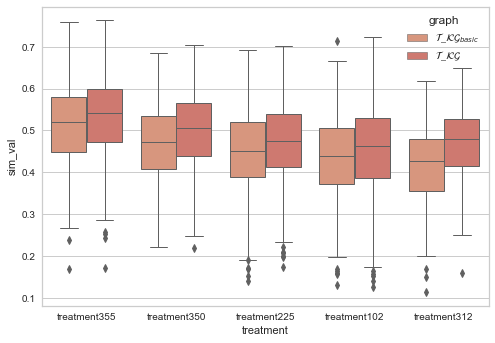

In [16]:
ax = sns.boxplot(x="treatment", y="sim_val", hue="graph", data=df3, 
                 palette=sns.color_palette("flare"), linewidth=1, saturation=0.7, width=0.8,)

In [17]:
ax.figure.savefig(fname='Plots/boxplot.pdf', format='pdf', bbox_inches='tight')